In [5]:
#https://github.com/gengshan-y/VCN
#https://github.com/google-research/opticalflow-autoflow/blob/main/src/dataset_lib/augmentations/aug_params.py

In [4]:
import cv2
import numpy as np
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

from PIL import Image
from nnflow import flow_to_image, CustomDataloaderCreator

In [496]:
if 'loader' in locals(): 
    del loader

loader = CustomDataloaderCreator(
    batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

loader.add_Kubric(
    root_dir="../../KubricFlow",
    split="validation",
    crop=False,
    crop_type="center",
    crop_size=[512,512],
    augment=True,
    norm_params= {"use":False, "mean":[127.5, 127.5, 127.5], "std":[127.5, 127.5, 127.5]},
    aug_params={
        "spatial_aug_params": {
            "enabled": False,
            "aug_prob": 1.0, 
            "stretch_prob": 1.0, #0.8, 
            "min_scale": -0.1, #-0.1, 
            "max_scale": 1.0, #1.0, 
            "max_stretch": 0.8, #0.2, 
            "flip": False, 
            "h_flip_prob": 0.0, 
            "v_flip_prob": 1.0
        },
        "color_aug_params":{
            "enabled": False,
            "aug_prob": 1.0, 
            "brightness": 0.4, 
            "contrast": 0.4, 
            "saturation": 0.4, 
            "hue": 0.5 / 3.14
        },
        "eraser_aug_params": {
            "enabled": False,
            "aug_prob": 1,
            "bounds": [50, 100]
        },
        "noise_params": {
            "enabled": False,
            "aug_prob": 1,
            "noise_std_range": 0.06
        },
        "spatial_params": {
            "enabled": True,
            "scale": [0.0, 0.03, 0.0], # [0.3, 0.03, 0.1] [scale1, 0.03, scale2]
            "rot": [0.4, 0.03], #[0.4, 0.03] [rot1, 0.03]
            "trans": [0.4, 0.03], #[0.4, 0.03] [tran1, 0.03]
            "squeeze": [0.0, 0.], #[0.3, 0.] [squeeze1, 0.]
            "black": False
        },
        "translate_params": {
            "enabled": False, 
            "aug_prob": 1.0,
            "translate": 10,
        },
        "rotate_params": {
            "enabled": False,
            "aug_prob": 1.0,
            "degrees": 10,
            "delta": 0,
        }
    }
)

In [497]:
ds = loader.dataset_list[0]

In [498]:
(img1, img2), flow = ds[57]

In [499]:
img1.shape, img2.shape, flow.shape, type(img1)

(torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]),
 torch.Size([2, 512, 512]),
 torch.Tensor)

In [500]:
img1 = Image.fromarray(np.uint8(img1.permute((1,2,0)).numpy()))
img2 = Image.fromarray(np.uint8(img2.permute((1,2,0)).numpy()))

flow = flow.permute((1,2,0))
flow = flow.numpy()

flow_color = flow_to_image(flow)
flow_color = Image.fromarray(np.uint8(flow_color))

img1.size, img2.size, flow_color.size

((512, 512), (512, 512), (512, 512))

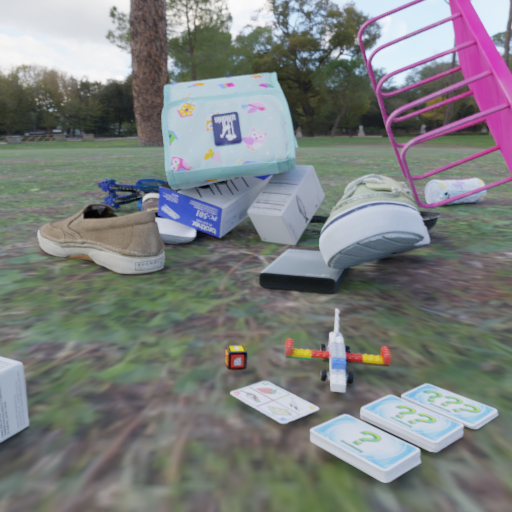

In [501]:
display(img1)

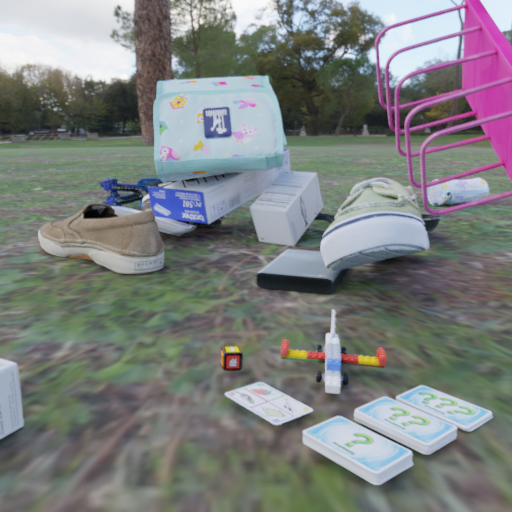

In [502]:
display(img2)

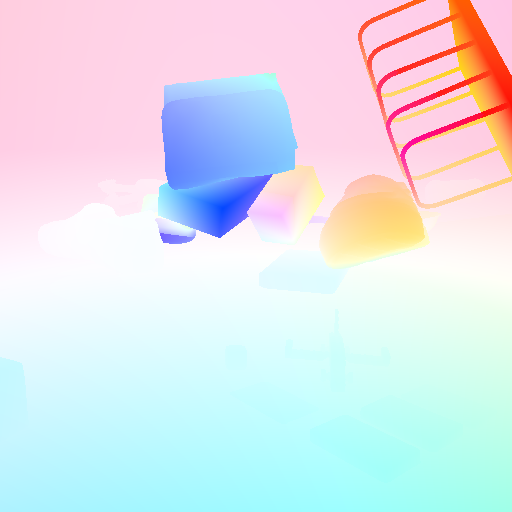

In [503]:
display(flow_color)

In [411]:
path = "../../augmentation_samples/"
aug_path = "spatial_aug/spatial/"

path += aug_path
path

'../../augmentation_samples/spatial_aug/spatial/'

In [412]:
img1.save(path + "frame_01.jpg")
img2.save(path + "frame_02.jpg")
flow_color.save(path + "flow_01.jpg")